In [1]:
#load up a bunch of different modules
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import matplotlib as plt
import numpy as np
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
from qiskit import Aer, execute
import sys
from gurobipy import *
#function to draw the graphs
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 

In [2]:
#This loads up all the graphs
#Change the directory to where you keep your file, this is meant for
G = nx.read_graph6("C:\\Users\\evilb\\Downloads\\graph8.g6")

#-----------------------#
#functions to run qaoa algorithm#
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
         # problem unitary
        
            
    qc.measure_all()
        
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

[[1 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


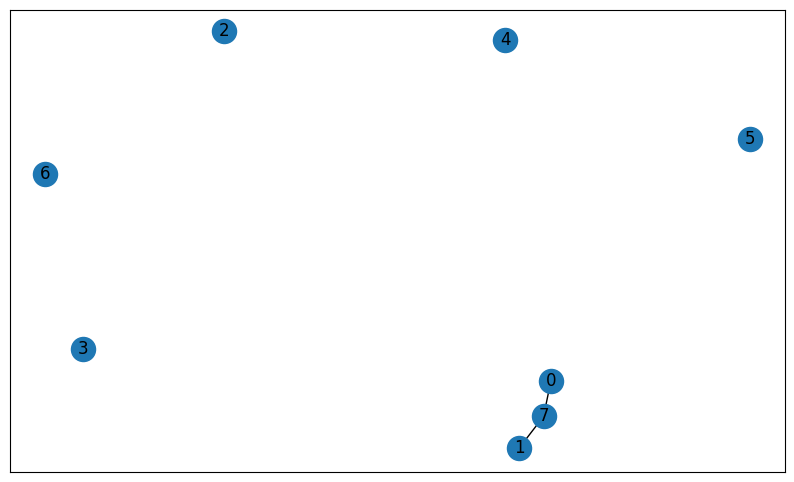

[(0, 7), (1, 7)]
12346


In [3]:
#function to represent the graphs as a adjacency matrix
def create_adjacency_matrix(edges):
    size = 8  # Assuming a 7x7 matrix
    matrix = [[0] * size for _ in range(size)]  # Initialize a 7x7 matrix with zeros
    # for i in range(size):
    #     matrix[i][i] = 1
    for edge in edges:
        row, col = edge
        if row <= col:
            matrix[row][col] = 1
            matrix[row][row] = 1
            matrix[col][col] = 1
            #matrix[col][row] =1 # Set the corresponding element to 1
    return matrix
#------------------------------------------#
#run this to create the adjacency matrix
graphs_matrix = []
graphs_optimized_sol = []
for i in range(0,len(G)):
    graphs_matrix.append(np.array(create_adjacency_matrix(G[i].edges())).reshape(-1))
graphs=np.array(graphs_matrix)
#test if it is what you want
print(np.array(graphs[2]).reshape(8,8))
DrawGraph(G[2])
print(G[2].edges())
print(len(G))

In [23]:
#write the true objective solution and binary solution with 
#this uses gurobi, so you will have to acquire a liscenese for it but students can get it free
graphs_optimized_sol = []
graphs_binary_sol = []
for k in range(len(G)):
    m = Model("mip1")
    m.setParam('OutputFlag', 0)
    x = {}
    y = {}
    for i in list(G[k].nodes):
        x[i] = m.addVar(vtype=GRB.BINARY, name= 'x' + str(i))
    for j in list(G[k].edges):
        y[j] = m.addVar(vtype=GRB.BINARY, obj=1, name= 'y' + str(j) )


    m.modelSense = GRB.MAXIMIZE
    m.update()
    for j in list(G[k].edges):
        m.addConstr( y[j] <= x[j[0]] + x[j[1]])
        m.addConstr( y[j] <= 2 - x[j[0]] +-x[j[1]])
    m.update()
    m.optimize()
    graphs_optimized_sol.append(np.binary_repr(int(m.objVal), width=8))
    binary_solution = {}
    for i in list(G[k].nodes):
        binary_solution[i] = int(x[i].X)
    #this doesn't matter because the neural network can not tell
    binary_sol=("".join(str(binary_solution[i]) for i in range(len(binary_solution))))
    graphs_binary_sol.append(binary_sol[::-1])

00000010
00000011


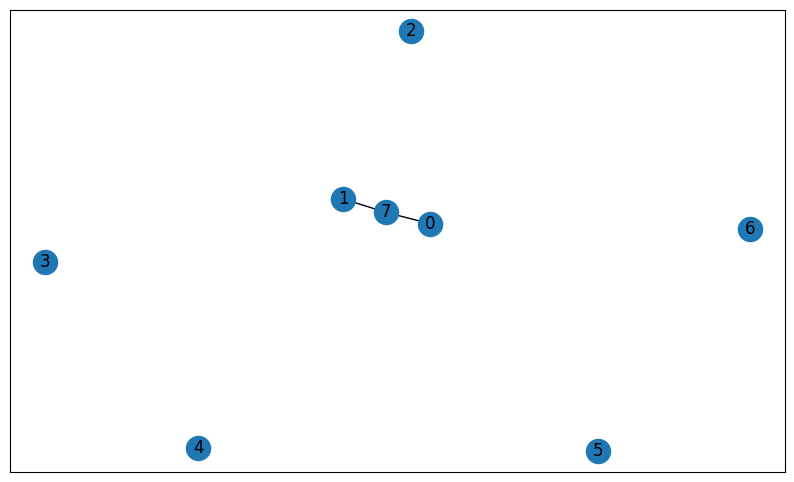

In [24]:
#check if works for small graphs
k = 2
print(graphs_optimized_sol[k])
print(graphs_binary_sol[k])
DrawGraph(G[k])

In [6]:
#run this to get all of the counts for every graph, will take about an hour
from scipy.optimize import minimize
import numpy as np
expectation=[]
res=[]
for x in range(0,len(G)):
    expectation.append(get_expectation(G[x]))
    res.append(minimize(expectation[x],
               [1,1],
               method='COBYLA'))
from qiskit.visualization import plot_histogram
qc_res=[]
counts=[]
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024
for i in range(0,len(G)):
    qc_res.append(create_qaoa_circ(G[i], res[i].x))
    counts.append(backend.run(qc_res[i], seed_simulator=10).result().get_counts())
    for state in counts[i]:
        counts[i][state]=counts[i][state]/backend.shots
#-------------------------------#
#make sure to save this data onto a file because you do not want to have to run this a second time
import json
file_path = "QAOACountsJuly7_8.json"
with open(file_path, "w") as file:
    json.dump(counts, file)

In [6]:
#open the counts so that you do not have to be demolished by wait time.
import json
with open("QAOACountsJuly7_8.json", "r") as file:
    data = json.load(file)
print(data[1])

{'10011110': 0.0087890625, '00101101': 0.0068359375, '00110011': 0.0087890625, '10000110': 0.0126953125, '10110100': 0.009765625, '11010110': 0.0068359375, '11101110': 0.0078125, '10010000': 0.0107421875, '00111111': 0.00390625, '00100001': 0.0048828125, '11111110': 0.005859375, '10100010': 0.0087890625, '11101000': 0.01171875, '10100100': 0.0146484375, '11010100': 0.0068359375, '00001011': 0.005859375, '01001101': 0.009765625, '01110001': 0.0068359375, '10101000': 0.00390625, '00000001': 0.0107421875, '01000111': 0.0126953125, '01111011': 0.0107421875, '01111001': 0.0048828125, '10101100': 0.009765625, '10010100': 0.0068359375, '00111011': 0.009765625, '00100101': 0.0048828125, '01011011': 0.001953125, '00000011': 0.0068359375, '00000101': 0.005859375, '11100000': 0.005859375, '01111111': 0.0107421875, '01000011': 0.0087890625, '00011001': 0.0087890625, '01000001': 0.009765625, '01111101': 0.009765625, '10011010': 0.0126953125, '11101010': 0.01171875, '11010010': 0.009765625, '0111011

In [9]:
binary_dict = {}

# Step 3: Assign the list of matrices as the value for the keys
binary_dict['graphs'] = graphs
binary_dict['counts'] = data
binary_dict['binary_sol'] = graphs_binary_sol
binary_dict['obj_sol'] = graphs_optimized_sol

# Now, the 'binary_dict' dictionary contains the list of matrices as the value for the keys
# You can access the matrices using binary_dict[key]
print(len(binary_dict['counts']))

12346


In [10]:
#I am generating binary strings for 2^n where n is equal to the number of nodes. For us n=8
def generate_binary_strings():
    binary_strings = []
    for i in range(256):
        binary_string = format(i, '08b')
        binary_strings.append(binary_string)
    return binary_strings
binary_strings = generate_binary_strings()
print(binary_strings)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

In [11]:
#reorder the counts in the dictionary so that you will not get errros later down the road.
counts = data
print(counts[0])
def order_dictionary(dictionary):
    ordered_dict = {}
    sorted_keys = binary_strings  # Sort the keys in ascending order
    for key in sorted_keys:
        ordered_dict[key] = dictionary.get(key, 0)  # Add key-value pairs to the ordered dictionary
    return ordered_dict
for i in range(0,len(counts)):
    data[i]=order_dictionary(counts[i])

print(data[0])
print(len(counts[0]))


{'10000111': 0.0087890625, '10110101': 0.0029296875, '10010001': 0.005859375, '11010110': 0.0048828125, '11000111': 0.0029296875, '11101110': 0.00390625, '00100000': 0.001953125, '10100011': 0.0029296875, '01100110': 0.0048828125, '00011100': 0.0029296875, '11111111': 0.0029296875, '01001110': 0.0048828125, '01110000': 0.001953125, '00101100': 0.00390625, '00110100': 0.0029296875, '10100101': 0.005859375, '00000010': 0.001953125, '01000100': 0.00390625, '01111010': 0.0048828125, '10101101': 0.005859375, '00100100': 0.0029296875, '00111100': 0.001953125, '11010010': 0.005859375, '01110111': 0.0029296875, '01001011': 0.0068359375, '01011010': 0.0009765625, '10110100': 0.0068359375, '01000000': 0.00390625, '01111110': 0.0048828125, '00011001': 0.0048828125, '01000001': 0.005859375, '01111101': 0.0048828125, '10101001': 0.0009765625, '00000000': 0.005859375, '10011010': 0.005859375, '00111011': 0.0068359375, '00100101': 0.001953125, '10010100': 0.0029296875, '00011000': 0.00390625, '010100

In [12]:
#print(binary_strings[1])
#the distribution has a symmetry of 0/1 thus we can fold the distribution in half to double the counts of available solutions
for j in range(0,len(counts)):
    dict_jdd = {}
    for i in range(128):
        dict_jdd[binary_strings[i]]=data[j][binary_strings[i]] + data[j][binary_strings[255-i]]
    data[j]=dict_jdd


128


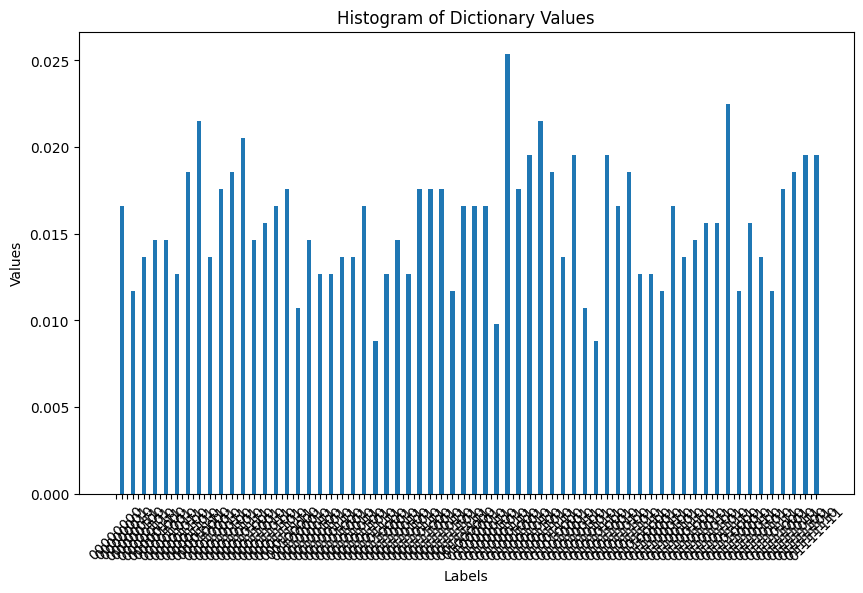

In [13]:
#check if works
print(len(counts[1]))
labels = list(data[1].keys())
values = list(data[1].values())

# Create a bar plot with custom x-axis labels
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram of Dictionary Values')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [25]:
#rewrite the dictionary and check if it works
binary_dict = {}
# Step 3: Assign the list of matrices as the value for the key 'graph'
binary_dict['graphs'] = graphs
binary_dict['counts'] = counts
binary_dict['binary_sol'] = graphs_binary_sol
binary_dict['obj_sol'] = graphs_optimized_sol

# Now, the 'binary_dict' dictionary contains the list of matrices as the value for the key 'graph'
# You can access the matrices using binary_dict['graph']
print(len(binary_dict['counts']))
print(counts[1])
print(binary_dict['graphs'][1].reshape(8,8))
print(graphs[1])

12346
{'00000000': 0, '00000001': 0.0166015625, '00000010': 0, '00000011': 0.01171875, '00000100': 0, '00000101': 0.013671875, '00000110': 0, '00000111': 0.0146484375, '00001000': 0, '00001001': 0.0146484375, '00001010': 0, '00001011': 0.0126953125, '00001100': 0, '00001101': 0.0185546875, '00001110': 0, '00001111': 0.021484375, '00010000': 0, '00010001': 0.013671875, '00010010': 0, '00010011': 0.017578125, '00010100': 0, '00010101': 0.0185546875, '00010110': 0, '00010111': 0.0205078125, '00011000': 0, '00011001': 0.0146484375, '00011010': 0, '00011011': 0.015625, '00011100': 0, '00011101': 0.0166015625, '00011110': 0, '00011111': 0.017578125, '00100000': 0, '00100001': 0.0107421875, '00100010': 0, '00100011': 0.0146484375, '00100100': 0, '00100101': 0.0126953125, '00100110': 0, '00100111': 0.0126953125, '00101000': 0, '00101001': 0.013671875, '00101010': 0, '00101011': 0.013671875, '00101100': 0, '00101101': 0.0166015625, '00101110': 0, '00101111': 0.0087890625, '00110000': 0, '001100

In [26]:
#save the dictionary to a pickle file
import pickle
# Specify the file path where you want to save the pickle file
file_path = 'QAOACountsJuly7_8.pkl'

# Open the file in binary mode and save the dictionary using pickle.dump()
with open(file_path, 'wb') as file:
    pickle.dump(binary_dict, file)

[[1 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
{'00000000': 0.0009765625, '00000001': 0.0068359375, '00000010': 0.00390625, '00000011': 0.0166015625, '00000100': 0, '00000101': 0.0009765625, '00000110': 0.0068359375, '00000111': 0.0205078125, '00001000': 0, '00001001': 0.00390625, '00001010': 0.0048828125, '00001011': 0.0185546875, '00001100': 0.0029296875, '00001101': 0.0107421875, '00001110': 0.0029296875, '00001111': 0.0234375, '00010000': 0.001953125, '00010001': 0.001953125, '00010010': 0.0068359375, '00010011': 0.0205078125, '00010100': 0.0009765625, '00010101': 0.009765625, '00010110': 0.0048828125, '00010111': 0.0234375, '00011000': 0.001953125, '00011001': 0.00390625, '00011010': 0.00390625, '00011011': 0.0205078125, '00011100': 0.0009765625, '00011101': 0.0048828125, '00011110': 0.005859375, '00011111': 0.0224609375, '00100000': 0.0009765625, '00100001': 0.0029296875, '00

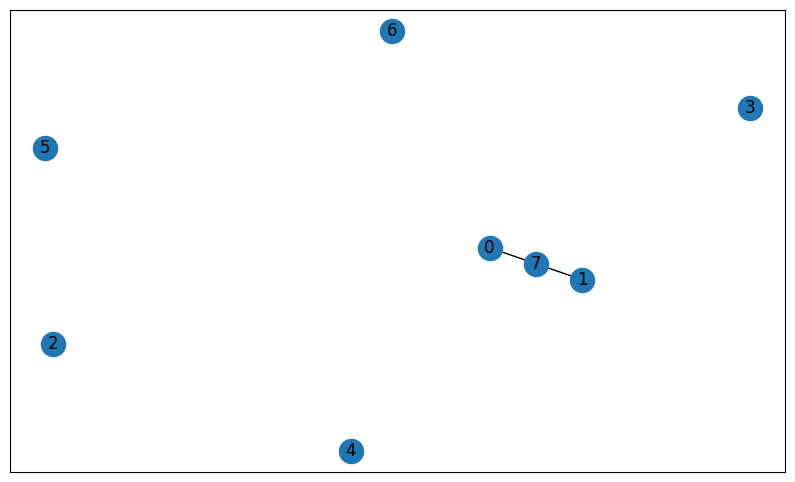

In [30]:
#check if it works right
with open(file_path, 'rb') as file:
    data_dict = pickle.load(file)

# Now you can use the loaded dictionary
print(data_dict['graphs'][2].reshape(8,8))
print(data_dict['counts'][2])
print(data_dict['binary_sol'][2])
print(data_dict['obj_sol'][2])
DrawGraph(G[2])

128


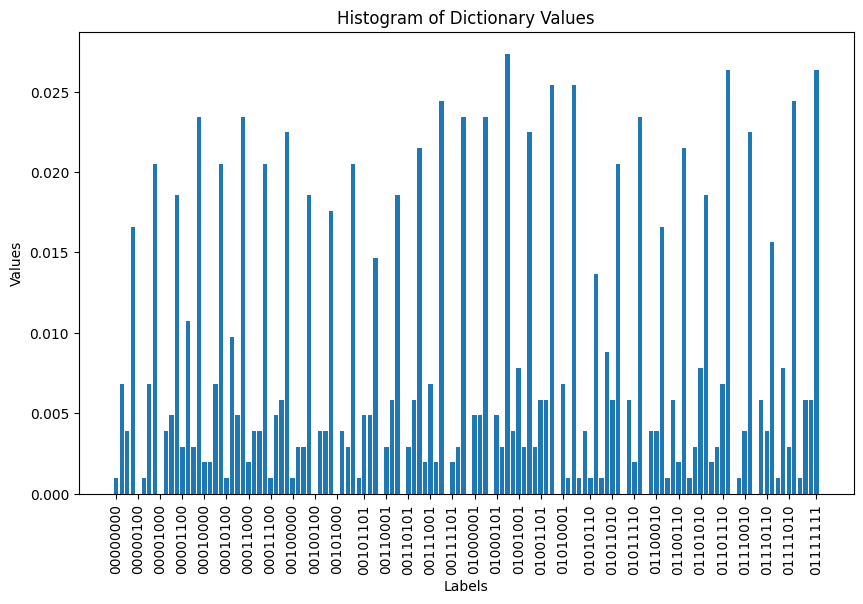

In [32]:
#check if works
print(len(counts[1]))
labels = list(data_dict['counts'][2].keys())
values = list(data_dict['counts'][2].values())

# Create a bar plot with custom x-axis labels
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram of Dictionary Values')

# Rotate x-axis labels for better readability (optional)
desired_ticks = 32
indices = np.linspace(0, len(labels)-1, desired_ticks).astype(int)
plt.xticks(indices, [labels[i] for i in indices], rotation='vertical')
# Display the plot
plt.show()